In [806]:
import pandas as pd
import numpy as np
import lightgbm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, root_mean_squared_error
import warnings
from datetime import datetime
import matplotlib.pyplot as plt
import shap
from sklearn.inspection import permutation_importance

In [807]:
warnings.filterwarnings('ignore')

In [808]:
train_df_final = pd.read_csv('./input/processed/train_df_final_v5.csv')
test_df_final = pd.read_csv('./input/processed/test_df_final_v5.csv')

In [809]:
train_df_final.head()

,id,climatology_temp,target,elev,doy_sin,doy_cos,day_length,day_frac,dew_point_avg,humidity_avg,...,dp_eve_doy_cos_slp_X_doy_sin_sq,STA_X_pt_sq_clim_doy_cos,ratio_slp_div_pt_X_STA,successful_STA_ratio_X_doy_sin,STA_x_dp_evening_doy_sin,base_ratio_slp_pt_X_clim_temp_doy_sin_sq,base_ratio_slp_pt_X_clim_temp_doy_cos_sq,elev_X_slp_avg,dp_evening_avg_X_humidity_avg,elev_slp_avg_X_STA_slp_avg
0,0,-2.707143,-3.992857,115.62,0.017213,0.999852,9.426812,0.392784,-16.808333,46.875000,...,-5.265843,28.104229,1565.878393,26.954022,0.850728,0.436699,1473.407450,119598.77325,-805.468750,-3.558264e+08
1,1,-3.646429,-1.653571,115.62,0.034422,0.999407,9.437325,0.393222,-17.466667,45.500000,...,-20.878745,9.330952,-1991.301558,-68.543809,1.240684,-4.065714,-3427.358575,119683.07950,-775.016667,-2.621579e+08
2,2,-2.694643,-0.005357,115.62,0.051620,0.998667,9.448699,0.393696,-17.645833,43.583333,...,-51.141552,1.130754,-6802.117246,-351.123029,2.514695,-18.597283,-6960.819029,119787.61925,-808.470833,-3.259246e+08
3,3,-2.501786,-0.898214,115.62,0.068802,0.997630,9.460926,0.394205,-11.966667,53.166667,...,-27.286868,268.074322,168.293086,11.578973,0.546750,1.404517,295.296759,119294.78900,-297.733333,-1.746654e+08
4,4,-2.625000,-1.775000,115.62,0.085965,0.996298,9.473997,0.394750,-15.729167,40.583333,...,-151.868359,5.132928,-492.547088,-42.341711,1.322521,-12.462690,-1673.975709,118848.68850,-814.372222,-9.366178e+07


In [810]:
features = [col for col in train_df_final.columns if col not in ['id', 'target']]

X = train_df_final[features].values
y = train_df_final['target'].values
X_test = test_df_final[features].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [811]:
lgbm = lightgbm.LGBMRegressor(
    n_estimators=5000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=52,
    verbose=-1
)

lgbm.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='rmse',
    callbacks=[lightgbm.log_evaluation(period=0),
               lightgbm.early_stopping(stopping_rounds=100, verbose=False)],
)

y_pred = lgbm.predict(X_val)
r2 = r2_score(y_val, y_pred)
rmse = root_mean_squared_error(y_val, y_pred)
print(f"\n✅ LightGBM R²: {r2:.4f} | RMSE: {rmse:.4f}")


✅ LightGBM R²: 0.8210 | RMSE: 1.2667


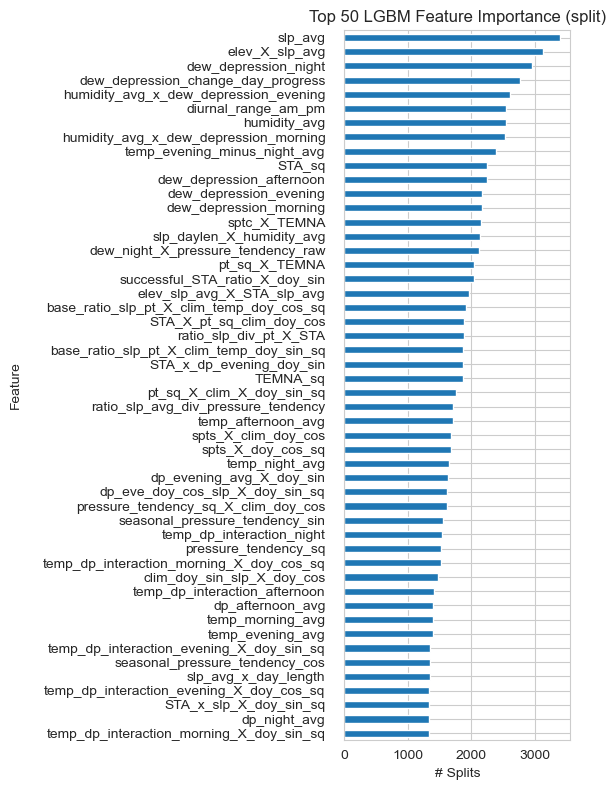

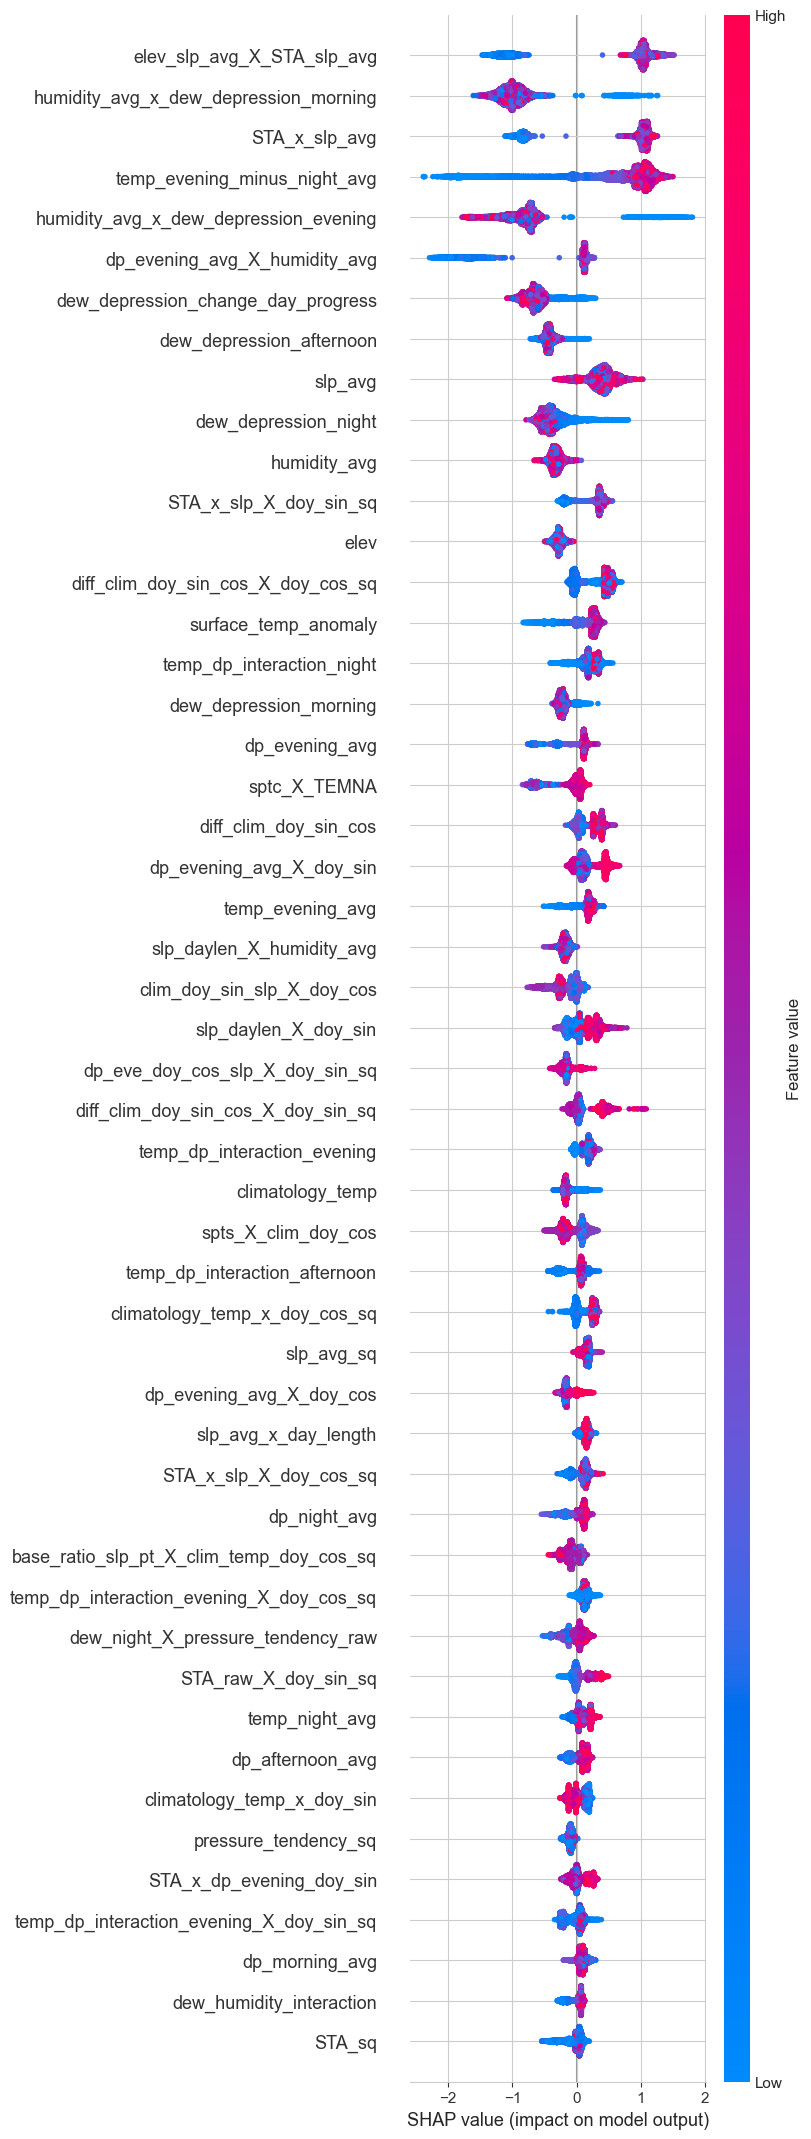

In [812]:
imp_split = lgbm.feature_importances_

feat_imp_split = pd.Series(imp_split, index=features).sort_values(ascending=False)

top_N = 50

# 1) Plot split importances
fig, ax = plt.subplots(figsize=(6, 8))
feat_imp_split.head(top_N).plot(kind='barh', ax=ax)
ax.invert_yaxis()
ax.set_title(f'Top {top_N} LGBM Feature Importance (split)')
ax.set_xlabel('# Splits')
ax.set_ylabel('Feature', labelpad=15)
ax.tick_params(axis='y', pad=10)
plt.subplots_adjust(left=0.3)
plt.tight_layout()
plt.show()

# 2) SHAP Summary Plots
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X, max_display=top_N, feature_names=features)
mean_abs_shap = np.abs(shap_values).mean(axis=0)
feat_shap_imp = pd.Series(mean_abs_shap, index=features).sort_values(ascending=False)

In [813]:
print(f"Top {top_N} LGBM Importances (split):")
print(feat_imp_split.head(top_N).to_string())
print("="*50)
print("Top SHAP Feature Importances (mean |SHAP value|):")
print(feat_shap_imp.head(top_N).to_string())

Top 50 LGBM Importances (split):
slp_avg                                     3389
elev_X_slp_avg                              3125
dew_depression_night                        2957
dew_depression_change_day_progress          2764
humidity_avg_x_dew_depression_evening       2600
diurnal_range_am_pm                         2552
humidity_avg                                2548
humidity_avg_x_dew_depression_morning       2524
temp_evening_minus_night_avg                2384
STA_sq                                      2243
dew_depression_afternoon                    2239
dew_depression_evening                      2174
dew_depression_morning                      2162
sptc_X_TEMNA                                2146
slp_daylen_X_humidity_avg                   2128
dew_night_X_pressure_tendency_raw           2124
pt_sq_X_TEMNA                               2041
successful_STA_ratio_X_doy_sin              2041
elev_slp_avg_X_STA_slp_avg                  1956
base_ratio_slp_pt_X_clim_temp_doy_co

# Predict with Test Dataset

In [814]:
y_test_pred = lgbm.predict(X_test_scaled)

submission = pd.DataFrame({
    "id": test_df_final["id"],
    "target": y_test_pred
})

now = datetime.now().strftime("%Y%m%d_%H%M%S")

submission.to_csv(f'./output/submission_{now}.csv', index=False)